In [1]:
import os
import glob
import cv2
import numpy as np
from copy import deepcopy   
import matplotlib.pyplot as plt
from natsort import natsorted
import os
import sys
import inspect
import itertools

Load Test Frames

In [2]:
images = []
for file in natsorted(glob.glob("png/*.jpg")):
    im = cv2.imread(file)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = cv2.resize(im, (240, 240), interpolation=cv2.INTER_AREA)
    images.append(im)

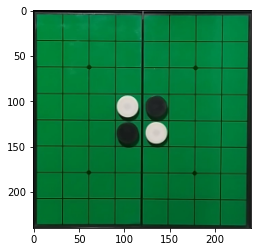

In [3]:
test_image = deepcopy(images[0])
plt.imshow(test_image)
plt.show()

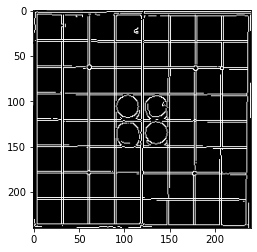

In [4]:
gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 25, 50, apertureSize=3)
plt.imshow(edges, cmap="gray")
plt.show()

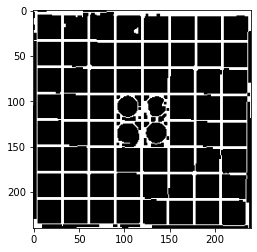

In [5]:
kernel = np.ones((3, 3), np.uint8)
edges = cv2.dilate(edges, kernel, iterations=1)
kernel = np.ones((3, 3), np.uint8)
edges = cv2.erode(edges, kernel, iterations=1)
# cv2.imwrite("canny.jpg", edges)
plt.imshow(edges, cmap="gray")
plt.show()

In [6]:
def preprocess_img(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 25, 50, apertureSize=3)
    kernel = np.ones((3, 3), np.uint8)
    edges = cv2.dilate(edges, kernel, iterations=1)
    kernel = np.ones((3, 3), np.uint8)
    edges = cv2.erode(edges, kernel, iterations=1)
    return edges

In [7]:
def get_lines(edges, filter=True, rho_threshold=15, theta_threshold=0.1):
    lines = cv2.HoughLines(edges,1,np.pi/180,170)
    # lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 50, None, 50, 10)

    if not lines.any():
        print('No lines were found')
        exit()

    if filter:
        # rho_threshold = 100
        # theta_threshold = 1

        # how many lines are similar to a given one
        similar_lines = {i : [] for i in range(len(lines))}
        for i in range(len(lines)):
            for j in range(len(lines)):
                if i == j:
                    continue

                rho_i,theta_i = lines[i][0]
                rho_j,theta_j = lines[j][0]
                if abs(rho_i - rho_j) < rho_threshold and abs(theta_i - theta_j) < theta_threshold:
                    similar_lines[i].append(j)

        # ordering the INDECES of the lines by how many are similar to them
        indices = [i for i in range(len(lines))]
        indices.sort(key=lambda x : len(similar_lines[x]))

        # line flags is the base for the filtering
        line_flags = len(lines)*[True]
        for i in range(len(lines) - 1):
            if not line_flags[indices[i]]: # if we already disregarded the ith element in the ordered list then we don't care (we will not delete anything based on it and we will never reconsider using this line again)
                continue

            for j in range(i + 1, len(lines)): # we are only considering those elements that had less similar line
                if not line_flags[indices[j]]: # and only if we have not disregarded them already
                    continue

                rho_i,theta_i = lines[indices[i]][0]
                rho_j,theta_j = lines[indices[j]][0]
                if abs(rho_i - rho_j) < rho_threshold and abs(theta_i - theta_j) < theta_threshold:
                    line_flags[indices[j]] = False # if it is similar and have not been disregarded yet then drop it now

    print('Number of Hough lines:', len(lines))

    filtered_lines = []

    if filter:
        for i in range(len(lines)): # filtering
            if line_flags[i]:
                filtered_lines.append(lines[i])

        print('Number of filtered lines:', len(filtered_lines))
    else:
        filtered_lines = lines

    line_coords = []

    for line in filtered_lines:
        rho,theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        # x1 = int(x0 + 1000*(-b))
        # y1 = int(y0 + 1000*(a))
        # x2 = int(x0 - 1000*(-b))
        # y2 = int(y0 - 1000*(a))
        x1 = int(x0 + 250*(-b))
        y1 = int(y0 + 250*(a))
        x2 = int(x0 - 250*(-b))
        y2 = int(y0 - 250*(a))
        line_coords.append([x1, y1, x2, y2])
    return line_coords

In [8]:
line_coords = get_lines(edges)

Number of Hough lines: 36
Number of filtered lines: 19


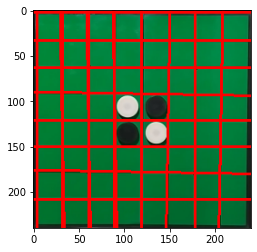

In [9]:
tmp_img = deepcopy(test_image)
for x1, y1, x2, y2 in line_coords:
    cv2.line(tmp_img,(x1,y1),(x2,y2),(255, 0, 0),2)
# for line in filtered_lines:
#     l = line[0]
#     cv2.line(test_image,(l[0],l[1]),(l[2],l[3]),(255, 0, 0),2)

# cv2.imwrite('hough.jpg',test_image)
plt.imshow(tmp_img)
plt.show()

In [10]:
def clean_lines(line_coords):
    horizontal_lines = []
    vertical_lines = []

    for l in line_coords:
        if abs(l[0]-l[2]) > abs(l[1]-l[3]):
            horizontal_lines.append(l)
        else :
            vertical_lines.append(l)

    horizontal_lines.sort(key=lambda x:x[1])
    vertical_lines.sort(key=lambda x:x[0])

    #delete close lines and add lines 
    i = 0
    while True:
        if i >= len(horizontal_lines)-1:
            break
        if horizontal_lines[i][1]<0:
            horizontal_lines.pop(i)
        dist = min(horizontal_lines[i+1][1]-horizontal_lines[i][1],
                    horizontal_lines[i+1][3]-horizontal_lines[i][3]) 
        if dist < 10:
            horizontal_lines.pop(i)
        if dist > 50:
            new_line = [
                horizontal_lines[i][0],
                horizontal_lines[i][1]+int(dist/2),
                horizontal_lines[i][2],
                horizontal_lines[i][3]+int(dist/2)
            ]
            horizontal_lines.insert(i+1, new_line)
        i += 1

    i = 0
    while True:
        if i >= len(vertical_lines)-1:
            break
        if vertical_lines[i][0]<0:
            vertical_lines.pop(i)
        dist = min(vertical_lines[i+1][0]-vertical_lines[i][0],
                    vertical_lines[i+1][2]-vertical_lines[i][2])
        if dist < 10:
            vertical_lines.pop(i+1)
        if dist > 50:
            new_line = [
                vertical_lines[i][0]+int(dist/2),
                vertical_lines[i][1],
                vertical_lines[i][2]+int(dist/2),
                vertical_lines[i][3]
            ]
            vertical_lines.insert(i+1, new_line)
        i += 1

    return horizontal_lines, vertical_lines

In [11]:
horizontal_lines, vertical_lines = clean_lines(line_coords)

8


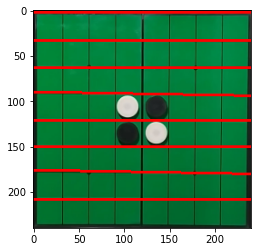

In [12]:
tmp_image = deepcopy(test_image)
print(len(horizontal_lines))
for l in horizontal_lines:
    cv2.line(tmp_image,(l[0],l[1]),(l[2],l[3]),(255, 0, 0),2)
# l = horizontal_lines[0]
# cv2.line(test_image,(l[0],l[1]),(l[2],l[3]),(255, 0, 0),2)
plt.imshow(tmp_image)
plt.show()

8


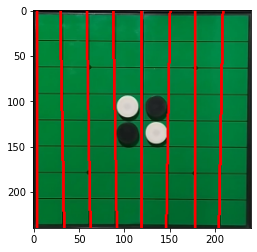

In [13]:

tmp_image = deepcopy(test_image)
print(len(vertical_lines))
for l in vertical_lines:
    cv2.line(tmp_image,(l[0],l[1]),(l[2],l[3]),(255, 0, 0),2)
# l = horizontal_lines[0]
# cv2.line(test_image,(l[0],l[1]),(l[2],l[3]),(255, 0, 0),2)
plt.imshow(tmp_image)
plt.show()

In [14]:
def get_grids(h_lines, v_lines, img, green_range=[[0, 70, 0], [100, 255, 100]]):
    widths = [v_lines[i+1][0]-v_lines[i][0] for i in range(len(v_lines)-1)]
    cell_width = int(np.mean(widths))
    heights = [h_lines[i+1][1]-h_lines[i][1] for i in range(len(h_lines)-1)]
    cell_height = int(np.mean(heights))
    lower = np.array(green_range[0], dtype = "uint8")
    upper = np.array(green_range[1], dtype = "uint8")
    
    n = 0
    while len(h_lines)<9 and n<2:
        first_line = h_lines[0]
        start_y = first_line[1]
        if start_y==0:
            start_y=1
        img_portion = img[:][0:start_y]
        mask = cv2.inRange(img_portion, lower, upper)
        green_area = cv2.bitwise_and(img_portion, img_portion, mask = mask)
        n += 1
        if sum(sum(sum(green_area)))>0 and h_lines[0][1]-cell_height>=0:
            new_line = [
                h_lines[0][0], 
                h_lines[0][1]-cell_height,
                h_lines[0][2],
                h_lines[0][3]-cell_height
                ]
            h_lines.insert(0, new_line)
        else :
            last_line = h_lines[-1]
            start_y = last_line[1]
            img_portion = img[:][start_y:]
            mask = cv2.inRange(img_portion, lower, upper)
            green_area = cv2.bitwise_and(img_portion, img_portion, mask = mask)
            n += 1
            if sum(sum(sum(green_area)))>0 and h_lines[-1][1]+cell_height<=img.shape[1]:
                new_line = [
                    h_lines[-1][0], 
                    h_lines[-1][1]+cell_height,
                    h_lines[-1][2],
                    h_lines[-1][3]+cell_height
                    ]
                h_lines.append(new_line)
    
    n = 0
    while len(v_lines)<9 and n<2:
        first_line = v_lines[0]
        start_x = first_line[0]
        if start_x==0:
            start_x = 1
        img_portion = img[:start_x][:]
        mask = cv2.inRange(img_portion, lower, upper)
        green_area = cv2.bitwise_and(img_portion, img_portion, mask = mask)
        # plt.imshow(green_area)
        # plt.show()
        # print(sum(sum(green_area)))
        n += 1
        if sum(sum(sum(green_area)))>0 and v_lines[0][0]-cell_width>=0:
            new_line = [
                v_lines[0][0]-cell_width, 
                v_lines[0][1],
                v_lines[0][2]-cell_width,
                v_lines[0][3]
                ]
            v_lines.insert(0, new_line)
        else :
            last_line = v_lines[-1]
            start_x = last_line[0]
            img_portion = img[start_x:][:]
            mask = cv2.inRange(img_portion, lower, upper)
            green_area = cv2.bitwise_and(img_portion, img_portion, mask = mask)
            n += 1
            if sum(sum(sum(green_area)))>0 and v_lines[-1][0]+cell_width<=img.shape[0]:
                new_line = [
                    v_lines[-1][0]+cell_width, 
                    v_lines[-1][1],
                    v_lines[-1][2]+cell_width,
                    v_lines[-1][3]
                ]
                v_lines.append(new_line)
    grids = []
    for j in range(len(v_lines)-1):
        grid_row = []
        for i in range(len(h_lines)-1):
            grid_row.append([ 
                int(np.mean([v_lines[j][0], v_lines[j][2]])),
                int(np.mean([h_lines[i][1], h_lines[i][3]])),
                int(np.mean([v_lines[j+1][0], v_lines[j+1][2]])),
                int(np.mean([h_lines[i+1][1], h_lines[i+1][3]]))
            ])
            # grid_row.append([ 
            #     [v_lines[j][0], v_lines[j][2]],
            #     [h_lines[i][1], h_lines[i][3]],
            #     [v_lines[j+1][0], v_lines[j+1][2]],
            #     [h_lines[i+1][1], h_lines[i+1][3]]
            # ])
        grids.append(grid_row)
    return grids

In [15]:
grids = get_grids(horizontal_lines, vertical_lines, test_image)

9


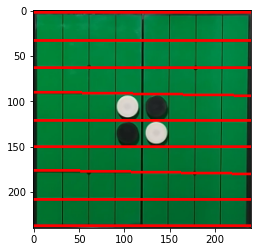

In [16]:
tmp_image = deepcopy(test_image)
print(len(horizontal_lines))
for l in horizontal_lines:
    cv2.line(tmp_image,(l[0],l[1]),(l[2],l[3]),(255, 0, 0),2)
# l = horizontal_lines[0]
# cv2.line(test_image,(l[0],l[1]),(l[2],l[3]),(255, 0, 0),2)
plt.imshow(tmp_image)
plt.show()

9


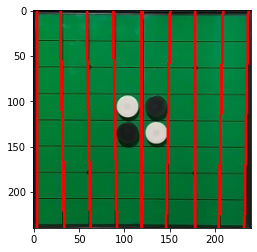

In [17]:
tmp_image = deepcopy(test_image)
print(len(vertical_lines))
for l in vertical_lines:
    cv2.line(tmp_image,(l[0],l[1]),(l[2],l[3]),(255, 0, 0),2)
# l = horizontal_lines[0]
# cv2.line(test_image,(l[0],l[1]),(l[2],l[3]),(255, 0, 0),2)
plt.imshow(tmp_image)
plt.show()

In [18]:
def is_color_in_range(color, range):
    min_vals = range[0]
    max_vals = range[1]
    for i, c in enumerate(color):
        if c < min_vals[i] or c > max_vals[i]:
            return False
    return True
    
def plot_grids(grids, img, 
                    black_range=[[0, 0, 0], [120, 120, 120]], 
                    white_range=[[140, 140, 140], [255, 255, 255]]):
    arr = []
    for g_row in grids:
        row = []
        for c in g_row:
            cell_height = c[3]-c[1]
            cell_width = c[2]-c[0]
            cell = img[
                        int(c[0]+cell_width/3):int(c[0]+cell_width*2/3), 
                        int(c[1]+cell_height/3):int(c[1]+cell_height*2/3)
                    ]
            
            center = [c[1]+cell_height//3, c[0]+cell_width//2]
            # plt.imshow(cell)
            # plt.show()

            #find dominant color
            pixels = np.float32(cell.reshape(-1, 3))
            n_colors = 3
            criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, .1)
            flags = cv2.KMEANS_RANDOM_CENTERS
            _, labels, palette = cv2.kmeans(pixels, n_colors, None, criteria, 10, flags)
            _, counts = np.unique(labels, return_counts=True)
            dominant = palette[np.argmax(counts)]
            # print(dominant)
            
            #separate black, white, and empty with thresholding
            if is_color_in_range(dominant, black_range):
                if dominant[1]-dominant[0] > 70:
                    cv2.putText(img, "0", (center[0], center[1]), 
                            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                            fontScale=0.4,
                            color=(255, 0, 0), 
                            thickness=2)
                    row.append(0)
                else :
                    cv2.putText(img, "-1", (center[0], center[1]), 
                                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                                fontScale=0.4,
                                color=(255, 0, 0), 
                                thickness=2)
                    row.append(-1)
            elif is_color_in_range(dominant, white_range):
                cv2.putText(img, "1", (center[0], center[1]), 
                            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                            fontScale=0.4,
                            color=(255, 0, 0), 
                            thickness=2)
                row.append(1)
            else :
                cv2.putText(img, "0", (center[0], center[1]), 
                            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                            fontScale=0.4,
                            color=(255, 0, 0), 
                            thickness=2)
                row.append(0)
        row = np.array(row)
        arr.append(row)
    arr = np.array(arr)
    return arr

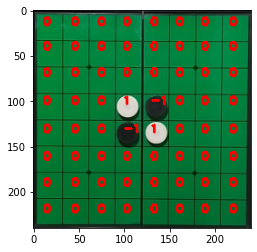

In [19]:
tmp_image = deepcopy(test_image)
arr = plot_grids(grids, tmp_image)
plt.imshow(tmp_image)
plt.show()

Test on frames with moving hands

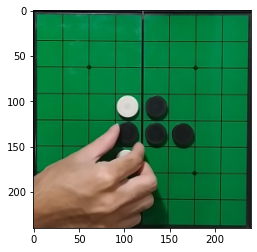

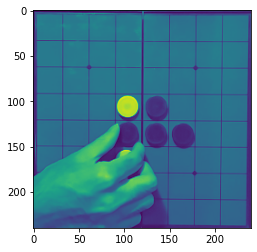

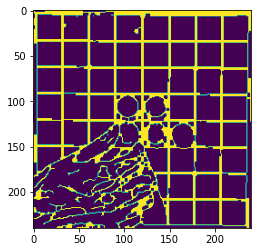

In [20]:
tmp = deepcopy(images[23])
plt.imshow(tmp)
plt.show()
gray = cv2.cvtColor(tmp, cv2.COLOR_BGR2GRAY)
plt.imshow(gray)
plt.show()
edges = cv2.Canny(gray, 25, 50, apertureSize=3)
kernel = np.ones((3, 3), np.uint8)
edges = cv2.dilate(edges, kernel, iterations=1)
kernel = np.ones((3, 3), np.uint8)
edges = cv2.erode(edges, kernel, iterations=1)
plt.imshow(edges)
plt.show()

Number of Hough lines: 23
Number of filtered lines: 12


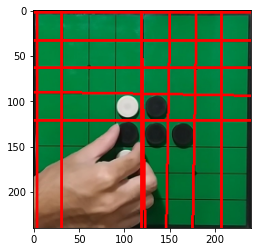

In [21]:
tmp = deepcopy(images[23])
line_coords = get_lines(edges)
for x1, y1, x2, y2 in line_coords:
    cv2.line(tmp, (x1,y1),(x2,y2),(255, 0, 0),2)

plt.imshow(tmp)
plt.show()

In [22]:
def detect_hands(img, skin_range=[[110, 80, 40], [140, 100, 60]]):
    for row in img:
        for v in row:
            if is_color_in_range(v, skin_range):
                return True
    return False

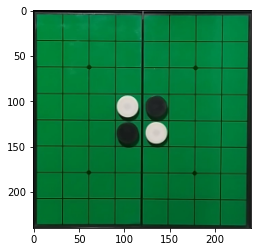

Hands Detected : False


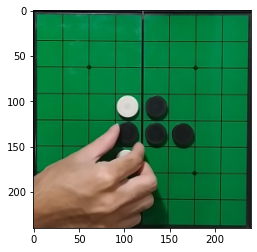

Hands Detected : True


In [23]:
tmp = deepcopy(images[0])
plt.imshow(tmp)
plt.show()
print("Hands Detected : {}".format(detect_hands(tmp)))

tmp = deepcopy(images[23])
plt.imshow(tmp)
plt.show()
print("Hands Detected : {}".format(detect_hands(tmp)))

Test on all test frames

In [24]:
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 
import board

In [25]:
#initialize grids and board status
tmp = deepcopy(images[0])
edges = preprocess_img(tmp)
line_coords = get_lines(edges)
horizontal_lines, vertical_lines = clean_lines(line_coords)
grids = get_grids(horizontal_lines, vertical_lines, tmp)

arr = plot_grids(grids, tmp)
b = board.Board(board_size=8)
b.board = arr
b.remaining_squares = sum(sum(arr==0))
b.score = {-1 : sum(sum(arr==-1)), 1: sum(sum(arr==1))}
b.current_tile = 1

positions = list(itertools.product(range(b.board_size), repeat = 2))
possible_moves = []
possible_states = []
for pos in positions:
    result = b.isValidMove(b.current_tile*-1, pos[0], pos[1])
    if result:
        tmp_board = deepcopy(b.board)
        tmp_board[pos[0]][pos[1]] = b.current_tile*-1
        for row in result:
            tmp_board[row[0]][row[1]] = b.current_tile*-1
        possible_moves.append(pos)
        possible_states.append(tmp_board)

b.printBoard()

Number of Hough lines: 36
Number of filtered lines: 19


In [31]:
save_path = "png_detection/"
if os.path.exists(save_path) and os.path.isdir(save_path):
    pass
else :
    os.makedirs(save_path)

for i, im in enumerate(images):
    tmp = deepcopy(im)

    if detect_hands(tmp):
        message = "Hand Detected. Passing this frame."
        print(message)
        cv2.rectangle(
            tmp, 
            pt1=(0, 0),
            pt2=(240, 30),
            color=(0, 0, 0), 
            thickness=-1)
        cv2.putText(
                tmp, 
                message, 
                (10, 20),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.40,
                (255, 0, 0),
                1
            )
        # plt.imshow(tmp)
        # plt.show()
        # cv2.imwrite(save_path + "frame{}.png".format(i), 
        #             cv2.cvtColor(tmp, cv2.COLOR_RGB2BGR))
        continue


    for l in horizontal_lines:
        cv2.line(tmp,(l[0],l[1]),(l[2],l[3]),(255, 0, 0),2)
    for l in vertical_lines:
        cv2.line(tmp,(l[0],l[1]),(l[2],l[3]),(255, 0, 0),2)

    arr = plot_grids(grids, tmp)
    if np.array_equal(arr, b.board):
        message = "No Position Change Detected"
        print("No Position Change Detected")
        # cv2.putText(
        #         tmp, 
        #         message, 
        #         (10, 20),
        #         cv2.FONT_HERSHEY_SIMPLEX,
        #         0.40,
        #         (0, 0, 255),
        #         1
        #     )
    else :
        new_move = False
        for idx, state in enumerate(possible_states):
            if np.array_equal(arr, state):
                message = "Next Position Detected. New Move : {}".format(possible_moves[idx])
                print(message)
                cv2.rectangle(
                    tmp, 
                    pt1=(0, 0),
                    pt2=(240, 30),
                    color=(0, 0, 0), 
                    thickness=-1)
                cv2.putText(
                        tmp, 
                        "New Move Detected", 
                        (10, 20),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.40,
                        (255, 0, 0),
                        1
                    )
                b.updateBoard(b.current_tile*-1,
                                possible_moves[idx][0],
                                possible_moves[idx][1])
                positions = list(itertools.product(range(b.board_size), repeat = 2))
                possible_moves = []
                possible_states = []
                for pos in positions:
                    result = b.isValidMove(b.current_tile*-1, pos[0], pos[1])
                    if result:
                        tmp_board = deepcopy(b.board)
                        tmp_board[pos[0]][pos[1]] = b.current_tile*-1
                        for row in result:
                            tmp_board[row[0]][row[1]] = b.current_tile*-1
                        possible_moves.append(pos)
                        possible_states.append(tmp_board)
                # b.printBoard()
                new_move = True
                break
        if not new_move:
            print("Position Invalid. Passing this Frame.")
    
    print(i)
    # plt.imshow(tmp)
    # plt.show()
    # cv2.imwrite(save_path + "frame{}.png".format(i), 
    #             cv2.cvtColor(tmp, cv2.COLOR_RGB2BGR))


No Position Change Detected
0
No Position Change Detected
1
No Position Change Detected
2
No Position Change Detected
3
Hand Detected. Passing this frame.
Hand Detected. Passing this frame.
Hand Detected. Passing this frame.
Hand Detected. Passing this frame.
Hand Detected. Passing this frame.
Hand Detected. Passing this frame.
Hand Detected. Passing this frame.
Hand Detected. Passing this frame.
Hand Detected. Passing this frame.
Hand Detected. Passing this frame.
Next Position Detected. New Move : (4, 5)
14
No Position Change Detected
15
No Position Change Detected
16
No Position Change Detected
17
No Position Change Detected
18
No Position Change Detected
19
Hand Detected. Passing this frame.
Hand Detected. Passing this frame.
Hand Detected. Passing this frame.
Hand Detected. Passing this frame.
Hand Detected. Passing this frame.
Hand Detected. Passing this frame.
Hand Detected. Passing this frame.
Next Position Detected. New Move : (5, 3)
27
No Position Change Detected
28
No Positi

In [24]:
# tmp = deepcopy(images[239])

# arr = plot_grids(grids, tmp)
# plt.imshow(tmp)
# plt.show()

In [25]:
# b.printBoard()

Evaluate Moves with CNN

In [26]:
import cnn
import torch

In [27]:
model_path = "../models/7conv-3fc-bn/7conv-3fc-bn-epoch-19.pth"
net = cnn.CNN7Conv()
net.load(model_path)
net.eval()

CNN7Conv(
  (conv1): Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [30]:
def get_moves_scores_states(b, net):
    player_state = (b.board==b.current_tile*-1)*1
    opponent_state = ((b.board)==b.current_tile)*1
    net_input = np.concatenate((
                player_state[None, ...], opponent_state[None, ...]), 
                axis=0)
    net_input = torch.Tensor(net_input)
    with torch.no_grad():
        output = net(net_input.unsqueeze(0))
    scores, indices = torch.sort(output, descending=True)
    indices = indices[0].numpy()
    scores = scores[0].numpy()
    
    positions = list(itertools.product(range(8), repeat=2))
    skipped = [(3, 3), (3, 4), (4, 3), (4, 4)]
    positions = [p for p in positions if p not in skipped]

    possible_moves = []
    possible_scores = []
    possible_states = []
    #get all possible moves
    for id, s in zip(indices,scores):
        pos = positions[id]
        result = b.isValidMove(b.current_tile*-1, pos[0], pos[1])
        if result:
            tmp_board = deepcopy(b.board)
            tmp_board[pos[0]][pos[1]] = b.current_tile*-1
            for row in result:
                tmp_board[row[0]][row[1]] = b.current_tile*-1
            possible_moves.append(pos)
            possible_scores.append(s)
            possible_states.append(tmp_board)
    return possible_moves, possible_scores, possible_states

Number of Hough lines: 36
Number of filtered lines: 19


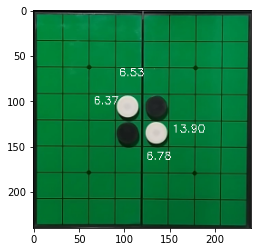

In [52]:
#initialize grids and board status
tmp = deepcopy(images[0])
edges = preprocess_img(tmp)
line_coords = get_lines(edges)
horizontal_lines, vertical_lines = clean_lines(line_coords)
grids = get_grids(horizontal_lines, vertical_lines, tmp)

arr = plot_grids(grids, tmp)
b = board.Board(board_size=8)
b.board = arr
b.remaining_squares = sum(sum(arr==0))
b.score = {-1 : sum(sum(arr==-1)), 1: sum(sum(arr==1))}
b.current_tile = 1

possible_moves, possible_scores, possible_states = get_moves_scores_states(b, net)
best_move = possible_moves[np.argmax(possible_scores)]

#plotting possible moves to the image
tmp = deepcopy(images[0])
for m, s in zip(possible_moves, possible_scores):
    c = grids[m[0]][m[1]]
    cell_height = c[3]-c[1]
    cell_width = c[2]-c[0]
    center = [c[1]+cell_height//6, c[0]+cell_width//2]
    cv2.putText(tmp, "{:.2f}".format(s), (center[0], center[1]), 
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=0.4,
                color=(255, 255, 255), 
                thickness=1)

plt.imshow(tmp)
plt.show()

No Position Change Detected
0


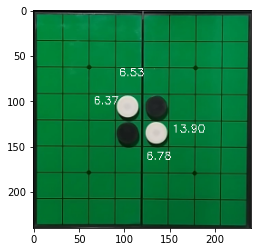

No Position Change Detected
1


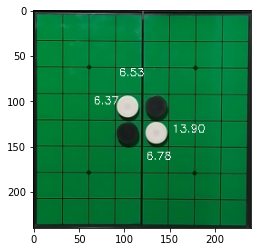

No Position Change Detected
2


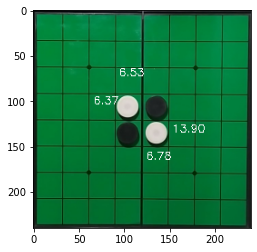

No Position Change Detected
3


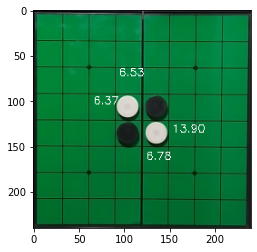

Hand Detected. Passing this frame.


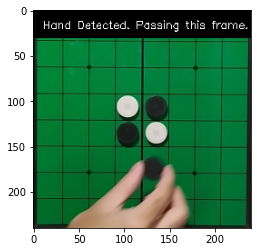

Hand Detected. Passing this frame.


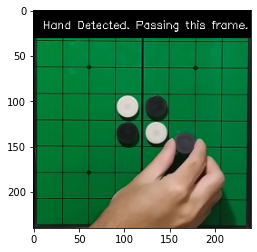

Hand Detected. Passing this frame.


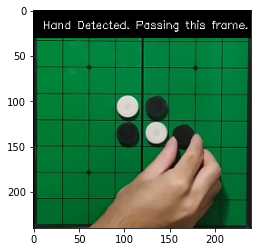

Hand Detected. Passing this frame.


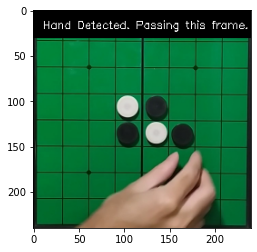

Hand Detected. Passing this frame.


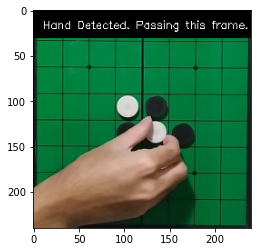

Hand Detected. Passing this frame.


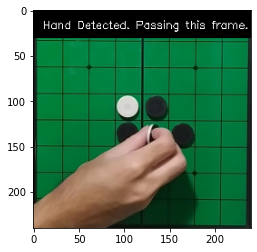

Hand Detected. Passing this frame.


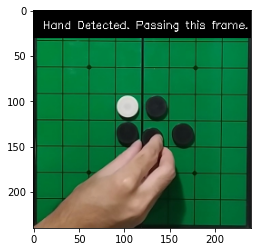

Hand Detected. Passing this frame.


KeyboardInterrupt: 

In [53]:
save_path = "png_evaluation/"
if os.path.exists(save_path) and os.path.isdir(save_path):
    pass
else :
    os.makedirs(save_path)

for i, im in enumerate(images):
    tmp = deepcopy(im)

    if detect_hands(tmp):
        message = "Hand Detected. Passing this frame."
        print(message)
        cv2.rectangle(
            tmp, 
            pt1=(0, 0),
            pt2=(240, 30),
            color=(0, 0, 0), 
            thickness=-1)
        cv2.putText(
                tmp, 
                message, 
                (10, 20),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.40,
                (255, 255, 255),
                1
            )
        # plt.imshow(tmp)
        # plt.show()
        cv2.imwrite(save_path + "frame{}.png".format(i), 
                    cv2.cvtColor(tmp, cv2.COLOR_RGB2BGR))
        continue

    arr = plot_grids(grids, tmp)
    tmp = deepcopy(im)
    
    if np.array_equal(arr, b.board):
        message = "No Position Change Detected"
        print(message)
        
    else :
        new_move = False
        for idx, state in enumerate(possible_states):
            if np.array_equal(arr, state):
                message = "Next Position Detected. New Move : {}".format(possible_moves[idx])
                print(message)
                cv2.rectangle(
                    tmp, 
                    pt1=(0, 0),
                    pt2=(240, 30),
                    color=(0, 0, 0), 
                    thickness=-1)
                cv2.putText(
                        tmp, 
                        "New Move:{}. Best Move:{}".format(possible_moves[idx], best_move), 
                        (10, 20),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.40,
                        (255, 255, 255),
                        1
                    )
                b.updateBoard(b.current_tile*-1,
                                possible_moves[idx][0],
                                possible_moves[idx][1])
                possible_moves, possible_scores, possible_states = get_moves_scores_states(b, net)
                best_move = possible_moves[np.argmax(possible_scores)]
                # b.printBoard()
                new_move = True
                break
        if not new_move:
            print("Position Invalid. Passing this Frame.")
    
    print(i)
    for m, s in zip(possible_moves, possible_scores):
        c = grids[m[0]][m[1]]
        cell_height = c[3]-c[1]
        cell_width = c[2]-c[0]
        center = [c[1]+cell_height//6, c[0]+cell_width//2]
        cv2.putText(tmp, "{:.2f}".format(s), (center[0], center[1]), 
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=0.4,
                    color=(255, 255, 255), 
                    thickness=1)
    # plt.imshow(tmp)
    # plt.show()
    cv2.imwrite(save_path + "frame{}.png".format(i), 
                cv2.cvtColor(tmp, cv2.COLOR_RGB2BGR))